In [1]:
%pylab inline
import cosmology as cosmo
import prepare as pre
from scipy import spatial
import sys
import healpy as hp
#import mpi4py.MPI as MPI
nside = 512
nside_ldp = 4096
from addpz_to_mock import *
import h5py

Populating the interactive namespace from numpy and matplotlib


In [2]:


class DENSITY():
    def __init__(self,om0,ol0):
        self.om0    = om0
        self.ol0    = ol0
        self.boxize = pre.boxize/1.
        self.boxhalf= pre.boxize/2.
        self.nx     = 512
        self.nsnap  = 9
        self.cM     = 300000. # km/s
        self.H0     = 100 #100h km/s /Mpc,h=0.1
        _zsnap      = np.loadtxt('snapz.dat')
        self.snap   = np.int32(_zsnap[:,0])
        self.zsnap  = _zsnap[:,1]
        self.zstart,self.zenderr,self.zend = 0.01,0.6,0.8 #0.8
        self.rstart  = cosmo.d_comoving(self.zstart,self.ol0,self.om0)
        self.renderr= cosmo.d_comoving(self.zenderr,self.ol0,self.om0)
        self.rend    = cosmo.d_comoving(self.zend,self.ol0,self.om0)
        
    def load_halo(self,dirh,i):
        xh          = np.load(dirh+'mlimit-3_simu'+pre.simu+'_Nsnap'+np.str(i)+'.npy')
        xh[:,:3]    = xh[:,:3]/1e3
        #period condition
        for i in np.arange(3):
            _id1,_id2  = (xh[:,i]<0),(xh[:,i]>self.boxize)
            xh[_id1,i]  = xh[_id1,i]+self.boxize
            xh[_id2,i] = xh[_id2,i]-self.boxize
        return xh
    
    def abundance(self,iz,Mag): #change for addpz
        self.coef1    = np.loadtxt('abundance/'+self.zobs[iz]+'-'+self.zobs[iz+1]+'Mag_Mh.dat')  # Mh to Mag
        self.coef2   = np.loadtxt('abundance/'+self.zobs[iz]+'-'+self.zobs[iz+1]+'Mh_Mag.dat')  # Mag to Mh
        _tmp          = (np.log10(self.xh[:,-1])+10).copy()
        index_m     = _tmp>np.polyval(self.coef2,-20)                      #This condition is useful 
        print('iz,abundance',iz,np.polyval(self.coef2,Mag),np.polyval(self.coef1,np.polyval(self.coef2,Mag)))
        self.xh[index_m,-1] = np.polyval(self.coef1,_tmp[index_m]) #tansform Mh to Mag, only operate for halos with masses larger than ...
        sys.stdout.write('abundance,nsub=%d\n'%(np.count_nonzero(index_m)))
        sys.stdout.flush()
        return self.xh[index_m]
    
    def gen_halo(self,Mag,flag_load,flag_order,flag_addpz): #change for addpz, change for 3rotations
        self.fname_base = 'BASSz'+np.str(self.zstart)+'-'+np.str(self.zend)+'_3rotation'+np.str(flag_order)
        self.zobs   = ['0.01','0.2','0.4','0.6','0.8']
        if(flag_load==0):
            for i in np.arange(self.nsnap-1)+1:
                _z1     = self.zsnap[i]
                _z2     = self.zsnap[i-1]
                _zm    = 0.5*(_z1+_z2)
                _iz      = np.min((np.int32(np.floor(_zm/0.2)),3)) #ensure z<0.8
                if(flag_load==0):
                    self.xh  = self.load_halo(dirh,self.snap[i])
                    print('snapshot=%d,z1=%lg,z2=%lg,zm=%lg,iz=%d,%d'%(self.snap[i],_z1,_z2,_zm,_iz,(np.int32(np.floor(_zm/0.2)))))
                    self.xh  = self.abundance(_iz,Mag)
                    if(i==1):  self.halo = self.xh.copy()
                    _d1      = cosmo.d_comoving(_z1,self.ol0,self.om0)
                    _d2      = cosmo.d_comoving(_z2,self.ol0,self.om0)
                    _tmp    = self.rotate(_d1,_d2,self.xh,flag_order)
                    #sys.stdout.write("_tmp.shape[0]=%d,shape[1]=%d,xh[:,-1].shape=%d\n"%(_tmp.shape[0],_tmp.shape[1],self.xh[:,-1].shape[0]))
                    sys.stdout.flush()
                    ##if(i==1): self.halo = _tmp #wrong?
                    if(i==1): self.halo = _tmp.copy()
                    else:     self.halo = np.append(self.halo,_tmp,0)
            ##index = (self.halo[:,2]>self.rstart)*(self.halo[:,2]<self.rend)
            ##self.halo = self.halo
            np.save(dirh+self.fname_base+'.npy',self.halo)
        if(flag_load==1):
            self.halo = np.load(dirh+self.fname_base+'.npy')

    def rotate(self,d1,d2,Pos,flag_order):        #change for 3rotations
        #xyz->yzx->zxy
        self.order = np.array([[0,1,2],[1,2,0],[2,0,1]])
        pos = np.zeros((Pos.shape[0],Pos.shape[1]))
        for i in np.arange(3):
            pos[:,i] = Pos[:,self.order[flag_order][i]].copy()
        pos[:,3]    = Pos[:,3].copy()
        
        n11  = np.int32(d1/self.boxize)
        n21  = np.int32(d2/self.boxize)
        sys.stdout.write("n11=%d,n21=%d,d1=%lg,d2=%lg,ng=%d\n"%(n11,n21,d1,d2,pos.shape[0]))
        sys.stdout.flush()
        if((n11==0) and (n21==0)): _pos = pre.pos_xyz(pos,0,d1,d2,2)
        if((n11==1) and (n21==1)): _pos  = pre.pos_xyz(pos,self.boxize,d1,d2,1)
        if((n11==2) and (n21==2)): _pos = pre.pos_xyz(pos,2*self.boxize,d1,d2,0)
        if((n11==0  and  n21==1) or (n11==1 and n21==2) or (n11==2 and n21==3)):
            _pos = pre.pos_xyz_rotate_slice(pos,n11,n21,d1,d2,self.boxize)
        sys.stdout.write("_pos.shape[0]=%d,shape[1]=%d\n"%(_pos.shape[0],_pos.shape[1]))
        return _pos

    def gen_edge_halo(self):
        self.dmax       = self.rend#self.boxize*3.
        self.ran        = np.zeros((3,2))
        r2 = np.sqrt(self.boxhalf**2.+self.dmax**2.)
        r3 = np.sqrt(r2**2.+self.boxhalf**2.)
        self.ran[0,1]   = np.arcsin(self.boxhalf/r3) #theta
        self.ran[1,1]   = np.arcsin(self.boxhalf/r2) #phi
        self.ran[0,0],self.ran[1,0] = -self.ran[0,1],-self.ran[1,1]
        #change for addpz
        self.ran[2,0],self.ran[2,1] = self.zstart,self.zenderr
        
    def gen_radec_addpz_halo(self,Mag1,Mag2,flag_radec,addpz,flag_addpz): #change for addpz #err in the early version
        self.fname_zerrbase = 'BASSz'+np.str(self.zstart)+'-'+np.str(self.zenderr)+'-'+np.str(self.zend)+'Mag1'+np.str(Mag1)+'Mag2'+np.str(Mag2)+'-addpz'+'_3rotation'+np.str(flag_order)
        #self.fname_zerrbase = 'BASSz'+np.str(self.zstart)+'-'+np.str(self.zenderr)+'-'+np.str(self.zend)+'Mag'+np.str(Mag2)+'-addpz'+'_3rotation'+np.str(flag_order)
        self.gen_edge_halo()
        if(flag_addpz==1): self.pzname  = ''
        if(flag_addpz==0): self.pzname = '_true_'
        if(flag_radec==0):
            dlz = dL_z(self.om0,self.ol0,-1.)
            self.radec = np.zeros((self.halo.shape[0],4))
            for i in np.arange(2):
                self.halo[:,i] = self.halo[:,i]-self.boxhalf
            _r2 = np.sqrt(self.halo[:,1]**2.+self.halo[:,2]**2.)
            self.radec[:,2] = np.sqrt(_r2**2.+self.halo[:,0]**2.)
            self.radec[:,0] = np.arcsin(self.halo[:,0]/self.radec[:,2])       #dec
            self.radec[:,1] = np.arcsin(self.halo[:,1]/_r2)                       #ra
            self.radec[:,3] = dlz.dC2z(self.radec[:,2])                          #change for addpz
            index = (self.radec[:,0]>self.ran[0,0])*(self.radec[:,0]<self.ran[0,1])*(self.radec[:,1]>self.ran[1,0])*(self.radec[:,1]<self.ran[1,1]) #change for addpz
            self.radec,self.halo = self.radec[index],self.halo[index]
            if(flag_addpz==1):  #addpz 
                addpz.add_pz(self.radec[:,-1],self.halo[:,-1],dlz)             # add zerr to redsfhit and Magnitude of mock galaxies !
                _nrank = np.count_nonzero(self.halo[:,-1]<Mag2)            # number of mock galaxies whose Magnitude is less than Mag
                _Mag   = addpz.Mag_h[addpz.Mag_h.argsort()][_nrank] # redo the abundace matching to the new Mag (considering zerr)
                print(_Mag)
                self.index = (self.halo[:,-1]>Mag1)*(addpz.Mag_h<_Mag2)*(addpz.z_h>self.ran[2,0])*(addpz.z_h<self.ran[2,1])  #change for addpz !
                self.radec[:,3]       = addpz.z_h.copy()
            else:   #do not add pz
                self.index = (self.halo[:,-1]>Mag1)*(self.halo[:,-1]<Mag2)*(self.radec[:,3]>self.ran[2,0])*(self.radec[:,3]<self.ran[2,1])
            np.save(dirh+self.fname_zerrbase+self.pzname+'radec.npy',self.radec[self.index])
        self.radec = np.load(dirh+self.fname_zerrbase+self.pzname+'radec.npy' )  #error here ! - change the name

    def gen_ldp(self,radius,flag_ldp):
        rr = radius/60.*np.pi/180
        self.nside_ldp = nside_ldp
        self.npix_ldp   = hp.nside2npix(self.nside_ldp)
        self.pix_ldp    = np.arange(self.npix_ldp)
        if(flag_ldp==0):
            thetal,phil   = hp.pix2ang(self.nside_ldp,self.pix_ldp,nest=True) #90-dec,ra
            ra_h,dec_h  = phil-pre.dra,np.pi/2-thetal #(ra here is not the standard ra)
            index         = np.where((ra_h>self.ran[1,0]) & (ra_h<self.ran[1,1]) & (dec_h>self.ran[0,0]) & (dec_h<self.ran[0,1]))
            self.radecl  = np.zeros((self.npix_ldp,2))
            self.radecl[:,0],self.radecl[:,1]= np.pi/2-thetal,phil-pre.dra #non-standard dec,ra-ldp
            self.index = index
            self.theta,self.phi = np.pi/2-self.radec[:,0],pre.dra+self.radec[:,1] #gal
            mask_ldp = np.ones(self.npix_ldp)
            vec_g  = hp.ang2vec(self.theta,self.phi) #galaxy
            for i in np.arange(self.theta.shape[0]):
                idx_search = hp.query_disc(self.nside_ldp,vec_g[i],rr,nest=True)
                mask_ldp[idx_search] = 0
            mask_edge = np.zeros(self.npix_ldp)
            mask_edge[index] = 1
            mask_ldp[mask_edge==0] = 0
            self.radecl = self.radecl[mask_ldp==1]
            np.save(dirh+self.fname_zerrbase+'rr'+np.str(radius)+'radec-ldp-obsMask-healpix.npy',self.radecl)
        self.radecl = np.load(dirh+self.fname_zerrbase+'rr'+np.str(radius)+'radec-ldp-obsMask-healpix.npy')
        
    def rr(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])*(x1[0]-x2[0])+(x1[1]-x2[1])*(x1[1]-x2[1]))
    
    def gen_mask_edge(self,Nside,a_the,a_phi): #change!
        _Npix        = hp.nside2npix(Nside)
        _Pix          = np.arange(_Npix)
        _theta,_phi = hp.pix2ang(Nside,_Pix,nest=True) #90-dec,ra
        _ra_h,_dec_h = _phi-pre.dra,np.pi/2-_theta #(ra here is not the standard ra)
        _index       = np.where( (_ra_h>self.ran[1,0]+a_phi) & (_ra_h<self.ran[1,1]+a_phi) & (_dec_h>self.ran[0,0]-a_the) & (_dec_h<self.ran[0,1]-a_the) )
        _Map        = np.zeros(_Npix)
        _Map[_index]= 1
        self.the_e,self.phi_e = _theta[_index],_phi[_index]
        return _Map
    
    def obs_Mask(self): #bright star Mask    #change!
        self.nside_Mask = 8192
        self.Mask = np.load('obs/randoms-dr7.1-0.22.0.8192mask.npy')#np.load('obs/Mask_cut50.npy')
        #self.nside_Mask = 512
        #self.Mask = np.load('obs/bassmask'+np.str(self.nside_Mask)+'.npy')
    
    def mask_galaxy(self,a_the,a_phi):
        self.theta,self.phi = np.pi/2-self.radec[:,0],pre.dra+self.radec[:,1] #gal
        _pix    = hp.ang2pix(self.nside_Mask,self.theta+a_the,self.phi+a_phi,nest=True)
        _index = self.Mask[_pix]>0
        self.radec = self.radec[_index]
    
    def gen_obsMask(self,a_the,a_phi):
        self.obs_Mask() #load bright star Mask
    
    def gen_den_map_Mask(self,ra,dec,flag_l,a_the,a_phi,flag_Mask): #change!
        self.nside= nside
        self.npix = hp.nside2npix(self.nside)
        self.pix   = np.arange(self.npix)
        _theta,_phi = np.pi/2-dec,ra+pre.dra
       
        if(flag_Mask==0):
            self.o_map     = pre.heapy_map(_theta,_phi,self.nside,True)
            self.mask_edge  = self.gen_mask_edge(self.nside,0,0)
            self.index_edge  = (self.mask_edge==1) #add Mask
            self.mask_name = 'no-Mask'
        if(flag_Mask==1):
            self.o_map       = pre.heapy_map(_theta+a_the,_phi+a_phi,self.nside,True) #change!
            self.mask_edge = self.gen_mask_edge(self.nside,a_the,a_phi)
            self.Mask_edge = np.load('obs/Mask_cut50.npy')
            self.index_edge = (self.mask_edge==1)*(self.Mask_edge==1)
            self.mask_name= '8192Mask'+np.str(id_center)
        
        self.g_mean   = np.mean(self.o_map[self.index_edge])
        self.o_map     = self.o_map/self.g_mean-1
        self.g_map     = -np.ones(self.npix)
        self.g_map[self.index_edge]     = self.o_map[self.index_edge]
        _theta,_phi  = hp.pix2ang(self.nside,self.pix,nest=True)
        self.theta_map,self.phi_map  = _theta[self.index_edge]-a_the,_phi[self.index_edge]-a_phi
        ##self.theta_map,self.phi_map  = _theta[self.index_edge],_phi[self.index_edge]
        if(flag_l==1): fname = self.fname_zerrbase+'rr'+np.str(radius)+self.pzname+'radec-ldp'
        if(flag_l==0): fname = self.fname_zerrbase+'rr'+np.str(radius)+self.pzname+'radec-gal'
        np.save(dirh+fname+'-den-'+self.mask_name+'-healpix.npy',np.vstack((self.theta_map,self.phi_map,self.g_map[self.index_edge]))) #y,x
        

[[-0.28158886  0.28158886]
 [-0.29346974  0.29346974]
 [ 0.01        0.6       ]]


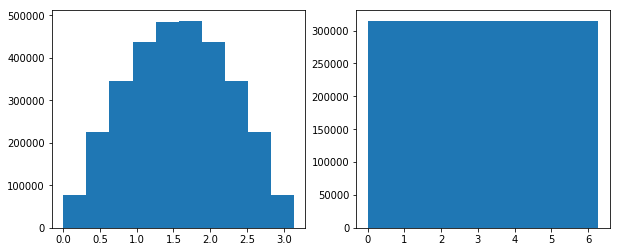

In [27]:
#plt.hist(density.halo[:,-1],bins=30,range=(-25,-21))
temp_Pix         = np.arange(hp.nside2npix(512))
temp_the,temp_phi = hp.pix2ang(512,temp_Pix,nest=True) #90-dec,ra
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(temp_the,label='theta')
plt.subplot(122)
plt.hist(temp_phi,label='phi')
print(density.ran)

In [3]:

class ADD_PZ():
    def __init__(self,dlz): # redshift for halo, Mag for halo, and the class dlz
        #load zerr of galaxies in BASS
        self.zbin  = np.array([0.01,0.2,0.4,0.6,0.8,1.2])
        self.zname = np.array(['0.01','0.2','0.4','0.6','0.8','1.2'])
        self.nzbin = self.zbin.shape[0]-1
        for i in np.arange(self.nzbin):
            label  = self.zname[i]+'-'+self.zname[i+1]
            _tmp   =  np.loadtxt('obs/R-Mag-z'+label+'-zerr.dat')
            if(i==0): self.xz = np.zeros((self.nzbin,_tmp.shape[0],_tmp.shape[1]))
            self.xz[i] = np.loadtxt('obs/R-Mag-z'+label+'-zerr.dat')
    def add_pz(self,z_h,Mag_h,dlz):
        self.z_h   = np.zeros(z_h.shape[0])
        self.Mag_h = np.zeros(z_h.shape[0])
        for i in np.arange(self.nzbin): # I do not add zerr to the bin[0.01,0.2]
            _index_g   = (z_h>self.zbin[i])*(z_h<self.zbin[i+1])
            if(i==0): self.z_h[_index_g] = z_h[_index_g].copy()  #?
            if(i>=1):
                _nrand     = np.count_nonzero(_index_g)
                self.zrand = gene_random_pdf(self.xz[i][0][0],(self.xz[i][1]-self.xz[i][0])[0],self.xz[i][2],_nrand)
                #plt.plot(0.5*(self.xz[i][0]+self.xz[i][1]),self.xz[i][2],label='input PDF')
                #plt.hist(self.zrand,bins=50,normed=True,label='generate random number')
                _zsign     = np.random.ranf(_nrand)
                index_sign = _zsign>0.5
                self.zrand[index_sign] = -1*self.zrand[index_sign]
                self.z_h[_index_g]      = z_h[_index_g].copy() + self.zrand
        _index_g   = self.z_h>0
        self.dMag = dlz.dMag12(z_h[_index_g],self.z_h[_index_g])
        self.Mag_h= Mag_h.copy()
        self.Mag_h[_index_g] = Mag_h[_index_g].copy() + self.dMag


In [171]:
density.ran[1]+a_phi

array([4.41891924, 5.00585872])

In [6]:
Mag1     = -21.5
Mag      = -21.2
radius    = 3#arcmin
om0,ol0   = 0.268,0.732
dirh      = '/home/dfy/work/cal_halo_6620/data/subhalo_pos/'
density   = DENSITY(om0,ol0)

# load subhalos and do abudance matching
flag_load = 1
# gain ra,dec for subhalos
flag_radec= 1
# generate the LDPs, 0-generate, 1-load
flag_ldp  =  0
# do not add pz
flag_addpz = 0
# xyz->yzx->zxy, decided by flag_order 
flag_order  = 1
#flag_Mask, 0-no obs Mask, 1-add obs Mask
flag_Mask = 0

dlz = dL_z(om0,ol0,-1.)
density.gen_halo(Mag,flag_load,flag_order,flag_addpz)  #remeber to change tomorrow!!!

addpz = ADD_PZ(dlz)
density.gen_radec_addpz_halo(Mag1,Mag,flag_radec,addpz,flag_addpz)

#temp_add   = np.array([[0,-np.pi*0.3],[-np.pi*0.1,np.pi*0.3],[0,np.pi*0.5],[-np.pi*0.1,np.pi*0.8]])#0.01-0.6-0.6
temp_add   = np.array([[0,np.pi*0.3],[0,np.pi*0.5],[0,np.pi*0.8]])#0.01-0.6-0.8
id_center    = 0

#Mask galaxies:
if(flag_Mask==1):
    a_the,a_phi = temp_add[id_center][0],temp_add[id_center][1] #-0.3->1.4
    density.gen_obsMask(a_the,a_phi)
    density.mask_galaxy(a_the,a_phi)
else:
    a_the,a_phi = 0,0
# gain density map for LDPs/galaxies,1-LDP,0-galaxy
flag_den_ldp = 0

if(flag_den_ldp==0):
    density.gen_den_map_Mask(density.radec[:,1],density.radec[:,0],flag_den_ldp,a_the,a_phi,flag_Mask)
if(flag_den_ldp==1):
    density.gen_ldp(radius,flag_ldp)
    density.gen_den_map_Mask(density.radecl[:,1],density.radecl[:,0],flag_den_ldp,a_the,a_phi,flag_Mask)


1030
4.8703558762382295


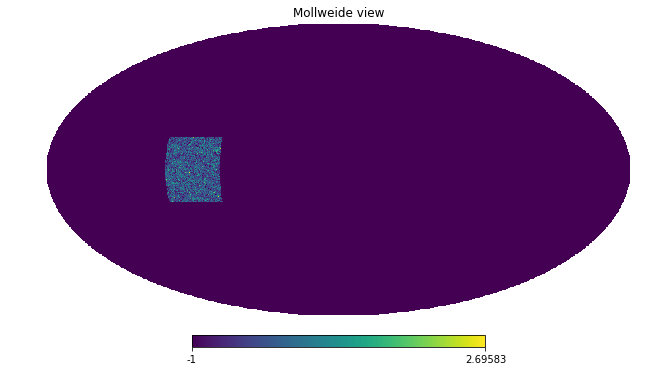

In [62]:
pix_temp = density.pix[density.index_edge]
print(np.count_nonzero(density.o_map[density.index_edge]==-1))
#index_temp = np.where(density.o_map[density.index_edge]==-1)
#density.o_map[pix_temp[index_temp]]=1
hp.mollview(density.o_map,nest=True)
print(density.g_mean)

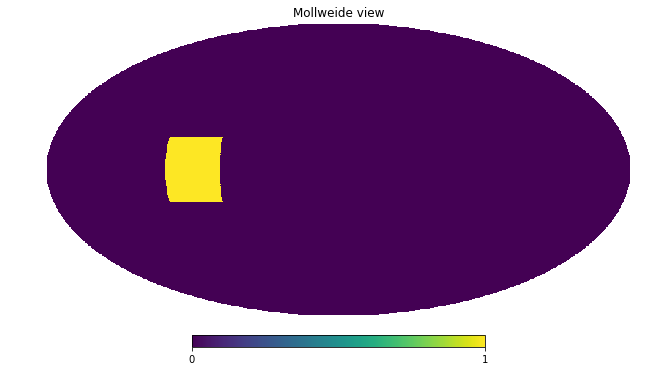

In [63]:
hp.mollview(density.mask_edge,nest=True)

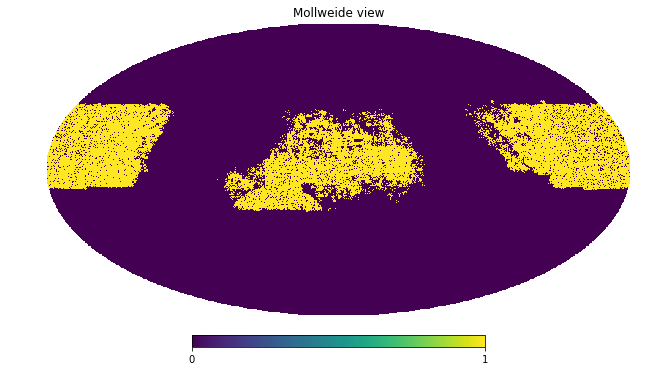

In [269]:
hp.mollview(density.Mask_edge,nest=True)

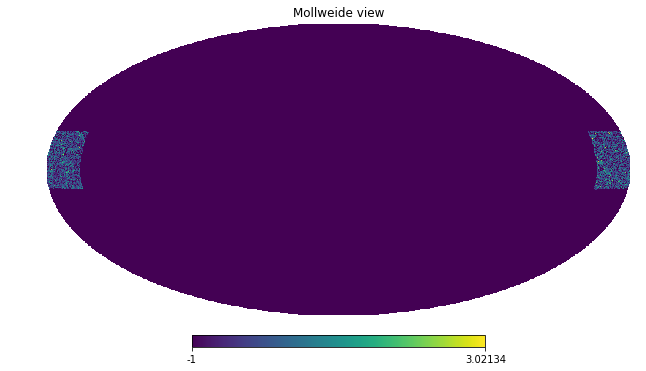

In [410]:
hp.mollview(density.g_map,nest=True)

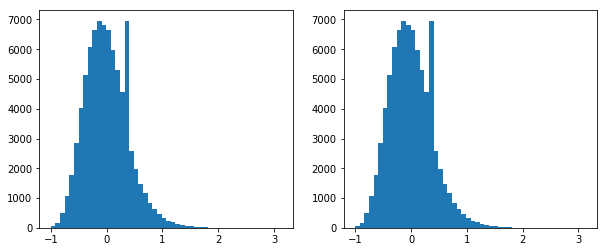

In [49]:
plt.figure(figsize=(10,4))
plt.subplot(121)
temp=plt.hist(density.o_map[density.index_edge],bins=50)
plt.subplot(122)
tmep=plt.hist(density.g_map[density.index_edge],bins=50)

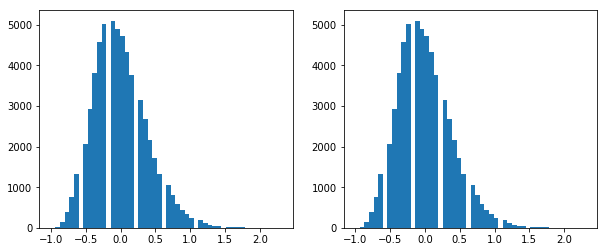

In [57]:
plt.figure(figsize=(10,4))
plt.subplot(121)
temp=plt.hist(density.o_map[density.index_edge],bins=50)
plt.subplot(122)
tmep=plt.hist(density.g_map[density.index_edge],bins=50)

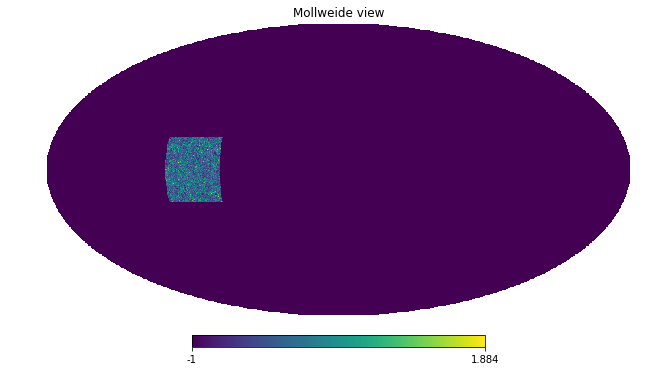

In [105]:
hp.mollview(density.o_map,nest=True)

(9082039, 4)


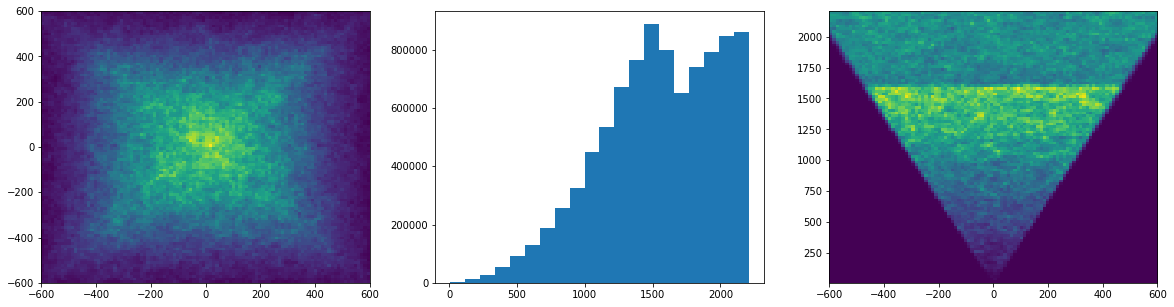

In [27]:
print(density.halo.shape)
plt.figure(figsize=(20,5))
plt.subplot(131)
temp = plt.hist2d(density.halo[:,0],density.halo[:,1],bins=(100,100))
plt.subplot(132)
temp = plt.hist(density.halo[:,2],bins=20)
plt.subplot(133)
temp = plt.hist2d(density.halo[:,0],density.halo[:,2],bins=(100,100))

(379390, 4)


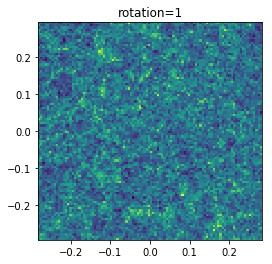

In [58]:
plt.figure(figsize=(4,4))
temp = plt.hist2d(density.radec[:,0],density.radec[:,1],bins=(100,100))
plt.title('rotation='+np.str(flag_order))
print(density.radec.shape)

(974824, 4)


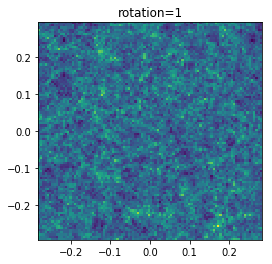

In [34]:
plt.figure(figsize=(4,4))
temp = plt.hist2d(density.radec[:,0],density.radec[:,1],bins=(100,100))
plt.title('rotation='+np.str(flag_order))
print(density.radec.shape)

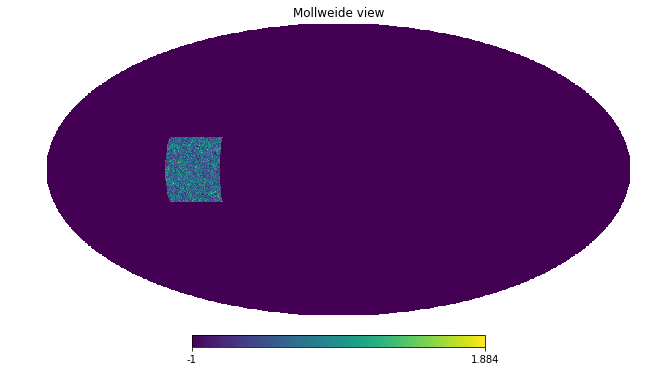

In [25]:
hp.mollview(density.g_map,nest=True )

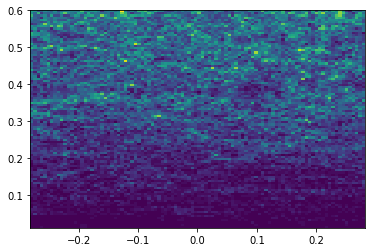

In [22]:
'''
plt.figure(figsize=(15,5))
plt.subplot(131)
temp = plt.hist2d(density.radec[:,0],density.radec[:,1],bins=(100,100))
print(density.radec.shape)
plt.subplot(132)
plt.title('no zerr')
temp = plt.hist2d(density.radec[:,0],density.radec[:,3],bins=(100,100))
plt.ylim(-0.1,1)
plt.subplot(133)
plt.title('add zerr')
temp = plt.hist2d(density.radec[:,0],addpz.z_h,bins=(100,100))
plt.ylim(-0.1,1)
'''
temp = plt.hist2d(density.radec[:,0],density.radec[:,3],bins=(100,100))
#print(density.radec.shape,addpz.z_h.shape)

In [67]:
plt.figure(figsize=(15,5))

temp = -22.2
index1 = (density.halo[:,-1]<temp+0.2)*(density.radec[:,3]>density.ran[2,0])*(density.radec[:,3]<density.ran[2,1])  #change for addpz !
index2 = (addpz.Mag_h<temp)*(addpz.z_h>density.ran[2,0])*(addpz.z_h<density.ran[2,1])  #change for addpz !
plt.subplot(131)
temp = plt.hist2d(density.radec[index1,0],density.radec[index1,3],bins=(100,100))
plt.colorbar()
plt.subplot(132)
temp = plt.hist2d(density.radec[index2,0],density.radec[index2,3],bins=(100,100))
plt.colorbar()
plt.ylim(0,0.6)

plt.subplot(133)
temp = plt.hist2d(density.radec[index2,0],addpz.z_h[index2],bins=(100,100))
#temp = plt.hist2d(density.radec[:,0],density.radec[:,3],bins=(100,100))
plt.colorbar()

ValueError: operands could not be broadcast together with shapes (27334887,) (74473,) 

<Figure size 1080x360 with 0 Axes>

/home/dfy/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-25, -21)

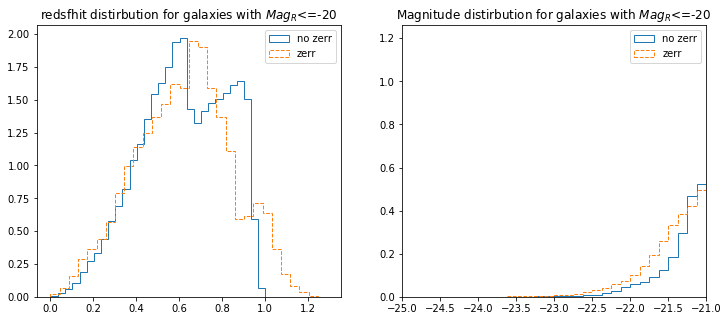

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(r'redsfhit distirbution for galaxies with $Mag_R$<=-20')
plt.hist(density.radec[:,3],bins=30,label='no zerr',histtype='step',normed=True)
plt.hist(addpz.z_h,bins=30,label='zerr',histtype='step',normed=True,ls='--')
plt.legend()
plt.subplot(122)
plt.title(r'Magnitude distirbution for galaxies with $Mag_R$<=-20')
plt.hist(density.halo[:,-1],bins=40,label='no zerr',histtype='step',normed=True,range=(-25,-20))
plt.hist(addpz.Mag_h,bins=40,label='zerr',histtype='step',normed=True,ls='--',range=(-25,-20))
plt.legend()
plt.xlim(-25,-21)
#plt.yscale('log')

In [170]:
density.halo[:,-1]

array([2113.1103 , 1993.5296 , 2101.7168 , ...,   53.51709,  153.204  ,
        140.647  ])

In [149]:
print(density.radec[:,3].shape,addpz.z_h.shape)

((544653,), (544653,))


[[-0.28158886  0.28158886]
 [-0.29346974  0.29346974]
 [ 0.01        0.6       ]]


(array([  26.,  160.,  251.,  363.,  803., 1104.,  803.,  474., 1153.,
        2598., 4194., 5161., 5941., 6501., 6337., 6256., 6245., 6304.,
        6607., 6579.]),
 array([0.01097072, 0.04042217, 0.06987363, 0.09932508, 0.12877653,
        0.15822798, 0.18767943, 0.21713089, 0.24658234, 0.27603379,
        0.30548524, 0.3349367 , 0.36438815, 0.3938396 , 0.42329105,
        0.45274251, 0.48219396, 0.51164541, 0.54109686, 0.57054832,
        0.59999977]),
 <a list of 20 Patch objects>)

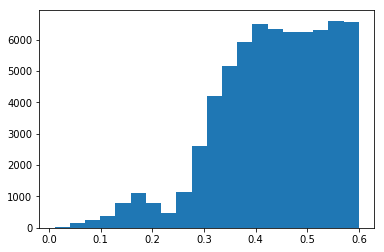

In [10]:
print(density.ran)
plt.hist(density.radec[:,3],bins=20)

In [20]:
density.gen_den_map_Mask(density.radec[:,1],density.radec[:,0],a_the,a_phi,0)

/home/dfy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in divide


In [17]:
density.g_map     = pre.heapy_map(_theta,_phi,self.nside,True)
hp.mollview(density.g_map,nest=True)

NameError: name '_theta' is not defined

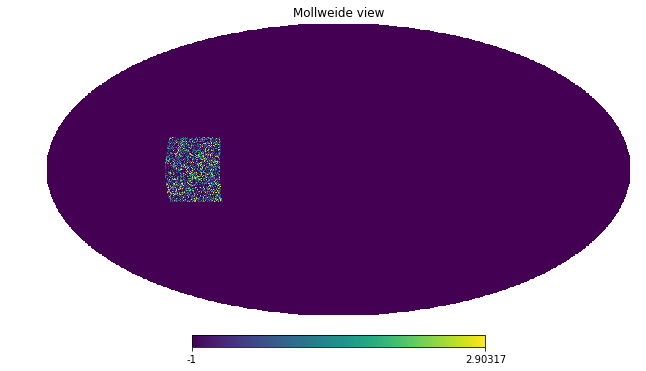

In [16]:
hp.mollview(density.o_map,nest=True)

(array([33667.,  4101.,  3858.,  5965.,  2626.,  2366.,  2186.,  4072.,
         1982.,  1864.,  3480.,  1592.,  1544.,  1418.,  3093.,  1492.,
         1349.,  2594.,  1218.,  1181.,  1200.,  2408.,  1064.,  1071.,
          962.,  1939.,  1003.,  1075.,  1901.,   903.,   834.,   860.,
         1688.,   833.,   728.,  1524.,   715.,   678.,   651.,  1364.,
          674.,   712.,  1247.,   593.,   505.,   728.,  1304.,   661.,
          550.,  4045.]),
 array([-1.        , -0.92761988, -0.85523976, -0.78285964, -0.71047952,
        -0.6380994 , -0.56571929, -0.49333917, -0.42095905, -0.34857893,
        -0.27619881, -0.20381869, -0.13143857, -0.05905845,  0.01332167,
         0.08570179,  0.1580819 ,  0.23046202,  0.30284214,  0.37522226,
         0.44760238,  0.5199825 ,  0.59236262,  0.66474274,  0.73712286,
         0.80950298,  0.8818831 ,  0.95426321,  1.02664333,  1.09902345,
         1.17140357,  1.24378369,  1.31616381,  1.38854393,  1.46092405,
         1.53330417,  1.6056842

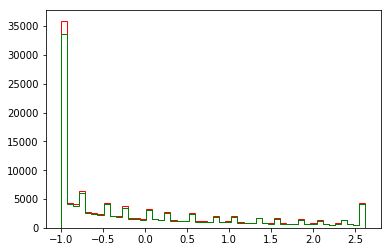

In [343]:
plt.hist(density.o_map[density.index_edge],bins=50,color='r',histtype='step')
plt.hist(density.g_map[density.index_Mask],bins=50,color='g',histtype='step')

In [289]:
print(np.count_nonzero(density.o_map[density.index_edge]==-1))

29108


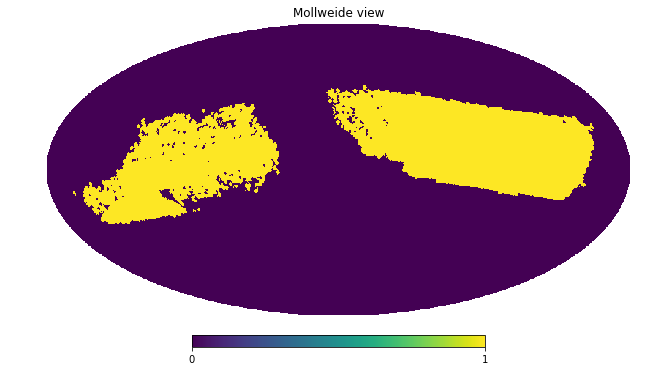

In [362]:
a_the,a_phi = np.pi*(-0.5),-np.pi*0.3
hp.mollview(density.Mask,rot=(a_the*180/np.pi,a_phi*0.15*180/np.pi,0),nest=True)

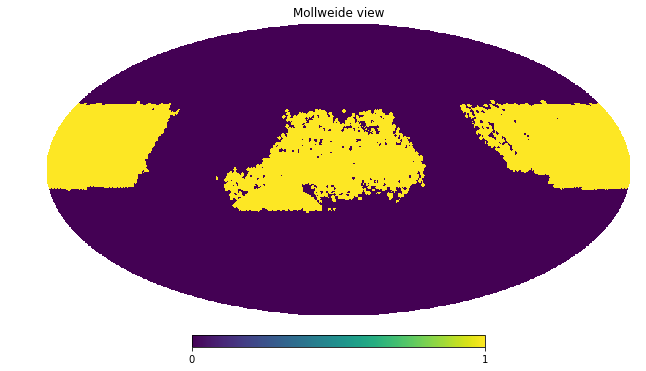

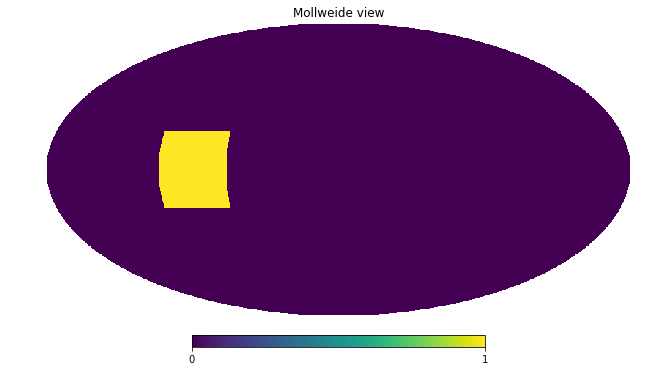

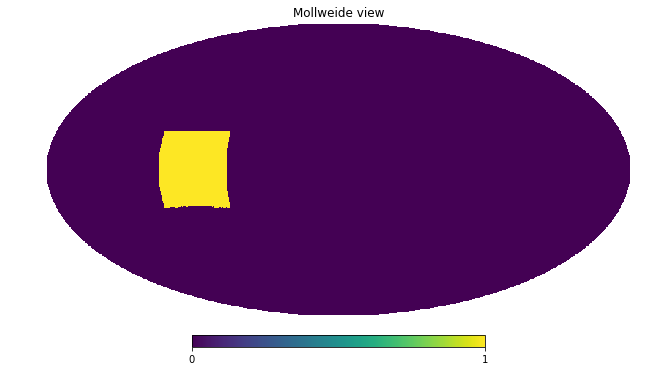

In [331]:
#Mask = np.load('obs/bassmask1024.npy')
hp.mollview(Mask,nest=True)
hp.mollview(density.mask_edge,nest=True)
hp.mollview(density.sMask,nest=True)